In [ ]:
#This script demonstrates how you can use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data.


In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

We will use the Numenta Anomaly Benchmark(NAB) dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

We will use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.csv file for testing. The simplicity of this dataset allows us to demonstrate anomaly detection effectively.

In [2]:
#load data
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url)

In [3]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


In [5]:
#Visualize the data
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

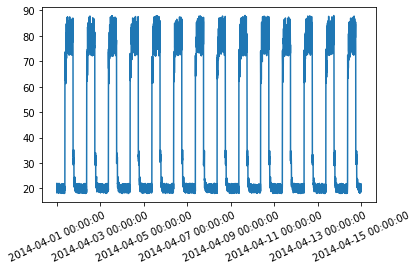

In [6]:
#Timeseries data without anomalies
#We will use the following data for training.
plot_dates_values(df_small_noise)

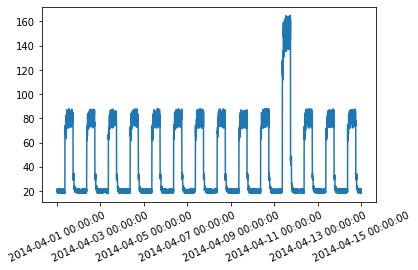

In [7]:
#Timeseries data with anomalies
#We will use the following data for testing and see if the sudden jump up in the data is detected as an anomaly.
plot_dates_values(df_daily_jumpsup)

Prepare training data
Get data values from the training timeseries data file and normalize the value data. We have a value for every 5 mins for 14 days.

24 * 60 / 5 = 288 timesteps per day
288 * 14 = 4032 data points in total

In [8]:
def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_small_noise)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)

4032

In [13]:
print(training_mean)
print(training_std)
print(training_value[:3])

42.43835333580657
28.07364027935401
[-0.85893509 -0.72908344 -0.84825292]


In [14]:
#Create sequences
#Create sequences combining TIME_STEPS contiguous data values from the training data.

TIME_STEPS = 288
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)


x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


Build a model
We will build a convolutional reconstruction autoencoder model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. In this case, sequence_length is 288 and num_features is 1.

In [22]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 288, 1)           

Param# 256 = filter# 32 * kernel# 7 + bias (filter#) = 32 * 8
Param# 3600 = filter_1# 32 * filter_2# 16 * 7 + bias (filter_2#) = 3584 + 16

In [23]:
#Train the model
#Please note that we are using x_train as both the input and the target since this is a reconstruction model.
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 47ms/step - loss: 0.5075 - val_loss: 0.0845
Epoch 2/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0836 - val_loss: 0.0431
Epoch 3/50
27/27 [==============================] - 1s 41ms/step - loss: 0.0602 - val_loss: 0.0393
Epoch 4/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0524 - val_loss: 0.0362
Epoch 5/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0461 - val_loss: 0.0347
Epoch 6/50
27/27 [==============================] - 1s 41ms/step - loss: 0.0413 - val_loss: 0.0327
Epoch 7/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0371 - val_loss: 0.0310
Epoch 8/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0335 - val_loss: 0.0292
Epoch 9/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0307 - val_loss: 0.0292
Epoch 10/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0284 - val_loss: 0.0279
Epoch 11/

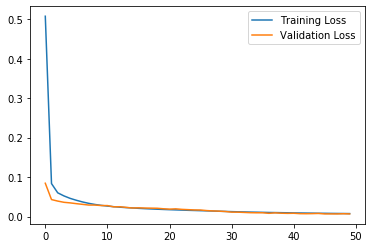

In [24]:
#Let's plot training and validation loss to see how the training went.

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Detecting anomalies
We will detect anomalies by determining how well our model can reconstruct the input data.

Find MAE loss on training samples.
Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

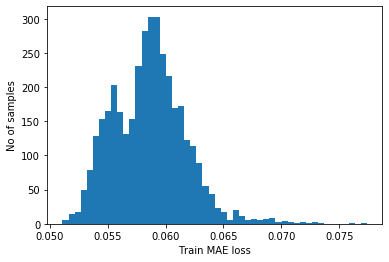

Reconstruction error threshold:  0.07738500477108226


In [25]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

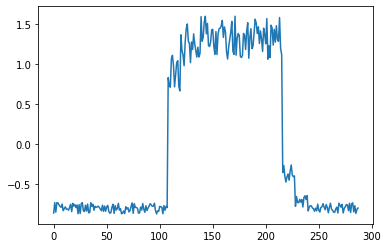

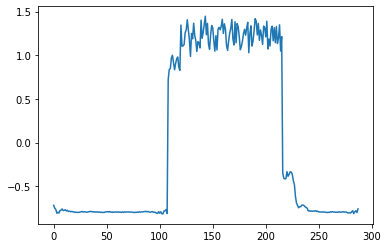

In [26]:
#Compare recontruction
#Just for fun, let's see how our model has recontructed the first sample. This is the 288 timesteps from day 1 of our training dataset.
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()


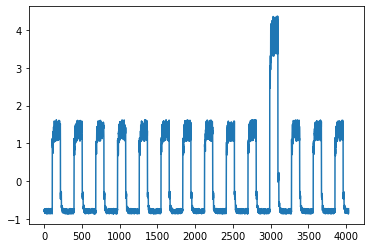

Test input shape:  (3744, 288, 1)


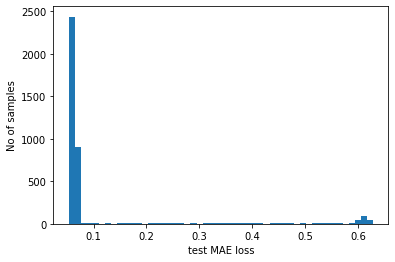

Number of anomaly samples:  399


In [28]:
#Prepare test data
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
#print("Indices of anomaly samples: ", np.where(anomalies))

Plot anomalies
We now know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data. We will be using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:

0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.

In [29]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

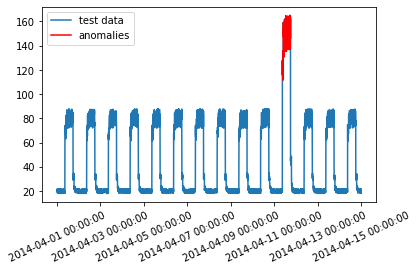

In [30]:
#Let's overlay the anomalies on the original test data plot.
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

Keras CNN Example with Keras Conv1D
This Keras Conv1D example is based on the excellent tutorial by Jason Brownlee. It shows how to develop one-dimensional convolutional neural networks for time series classification, using the problem of human activity recognition.

In [ ]:
#1. Load training and testing datasets
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [ ]:
#2. Fit and evaluate model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    # _ represents the loss (ignored)
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy


We will repeat the evaluation of the model multiple times, then summarize the performance of the model across each of those runs. For example, we can call evaluate_model() a total of 10 times. This will result in a population of model evaluation scores that must be summarized.

In [ ]:
#3. Summarize results
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()